In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
archivo = 'csv_creados/Data_Argentina_Relative_Terms.csv'
df = pd.read_csv(archivo)
df.head(2)

,year,GDP_Current,GDP_Constant,Broad_Money,Inflation,Velocity_Money
0,1961-12-31,0.268410,0.054278,-0.003597,0.203107,0.272007
1,1962-12-31,0.277738,-0.008520,0.101083,0.288718,0.176655


In [4]:
df.columns

Index(['year', 'GDP_Current', 'GDP_Constant', 'Broad_Money', 'Inflation',
       'Velocity_Money'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63 entries, 0 to 62
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            63 non-null     object 
 1   GDP_Current     63 non-null     float64
 2   GDP_Constant    63 non-null     float64
 3   Broad_Money     63 non-null     float64
 4   Inflation       63 non-null     float64
 5   Velocity_Money  63 non-null     float64
dtypes: float64(5), object(1)
memory usage: 3.1+ KB


In [6]:
df['year'] = pd.to_datetime(df['year'])

In [7]:
df.isnull().sum()

year              0
GDP_Current       0
GDP_Constant      0
Broad_Money       0
Inflation         0
Velocity_Money    0
dtype: int64

In [8]:
df.describe()

,year,GDP_Current,GDP_Constant,Broad_Money,Inflation,Velocity_Money
count,63,63.000000,63.000000,63.000000,63.000000,63.000000
mean,1992-12-30 14:51:25.714285696,1.591292,0.023335,1.374111,1.604749,0.217181
min,1961-12-31 00:00:00,-0.054563,-0.108945,-0.194362,-0.035611,-0.668046
25%,1977-07-01 12:00:00,0.201713,-0.020096,0.211689,0.151588,-0.140163
50%,1992-12-31 00:00:00,0.331365,0.028118,0.349018,0.288718,-0.033770
75%,2008-07-01 00:00:00,0.966935,0.065438,1.115077,1.005334,0.073334
max,2023-12-31 00:00:00,28.209270,0.107180,22.351819,30.460912,9.113007
std,NaN,4.390996,0.054967,3.230300,4.660917,1.389316


Mostramos la distribucion de nuestra varaible objetivo

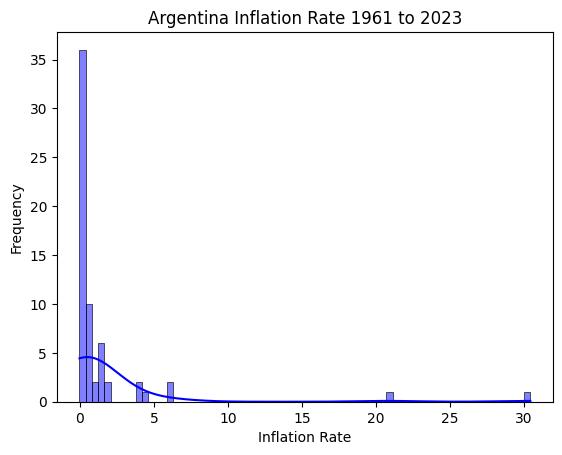

In [9]:
sns.histplot(df['Inflation'], kde=True, color='blue')
plt.title('Argentina Inflation Rate 1961 to 2023')
plt.xlabel('Inflation Rate')
plt.ylabel('Frequency')
plt.show()

In [10]:
IQR_Inflation_Rate = df['Inflation'].quantile(0.75) - df['Inflation'].quantile(0.25)
IQR_Inflation_Rate

np.float64(0.853746082987118)

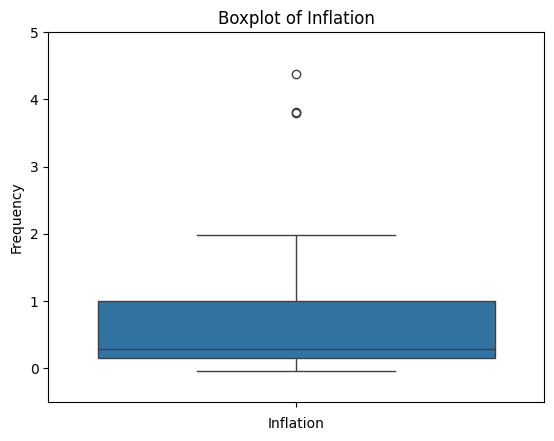

In [11]:
sns.boxplot(df['Inflation'])
plt.title('Boxplot of Inflation')
plt.xlabel('Inflation')
plt.ylabel('Frequency')
plt.ylim(-0.5, 5)
plt.show()

Manejamos los outliers de momento

In [12]:
df1 = df.copy()

upper_bond = 4*IQR_Inflation_Rate + df1['Inflation'].quantile(0.75)
lower_bond = df1['Inflation'].quantile(0.25) - 4*IQR_Inflation_Rate

df2 = df1[(df1['Inflation'] <= upper_bond) & (df1['Inflation'] >= lower_bond)]

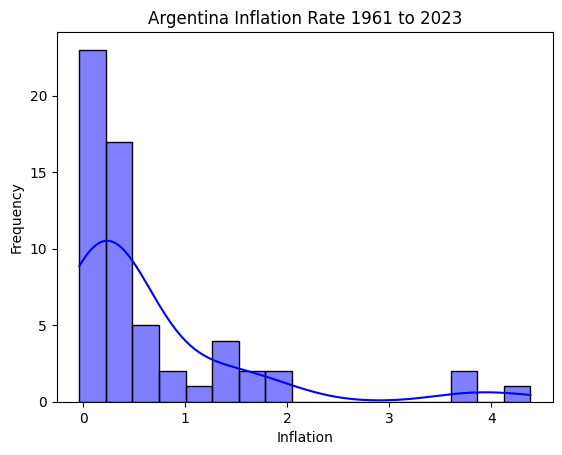

In [13]:
sns.histplot(df2['Inflation'], kde=True, color='blue')
plt.title('Argentina Inflation Rate 1961 to 2023')
plt.xlabel('Inflation')
plt.ylabel('Frequency')
plt.show()

Replicamos para Broad Money

In [14]:
IQR_Inflation_Rate = df1['Broad_Money'].quantile(0.75) - df1['Broad_Money'].quantile(0.25)

upper_bond = 4*IQR_Inflation_Rate + df1['Broad_Money'].quantile(0.75)
lower_bond = df1['Broad_Money'].quantile(0.25) - 4*IQR_Inflation_Rate

df3 = df2[(df2['Broad_Money'] <= upper_bond) & (df2['Broad_Money'] >= lower_bond)]


In [15]:
df3.to_csv('csv_creados/df_arc_normalized.csv',index=False)

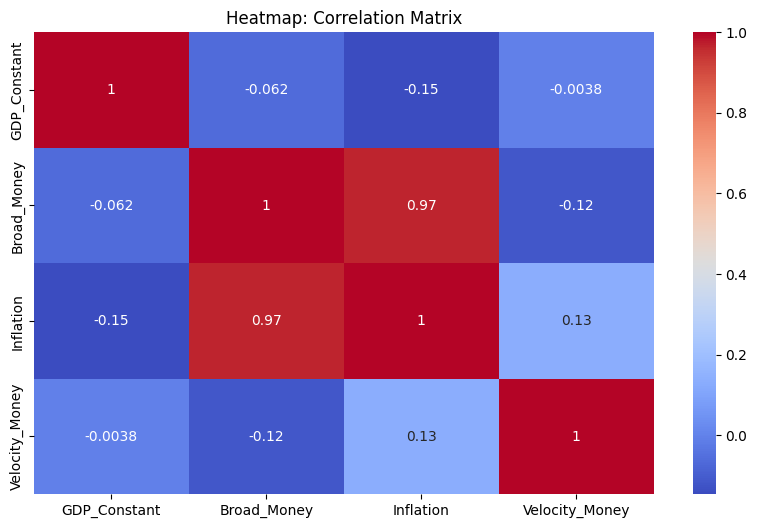

In [16]:
n_columns = ['GDP_Constant', 'Broad_Money', 'Inflation',
       'Velocity_Money']
correlation_matrix = df3[n_columns].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heatmap: Correlation Matrix')
plt.show()

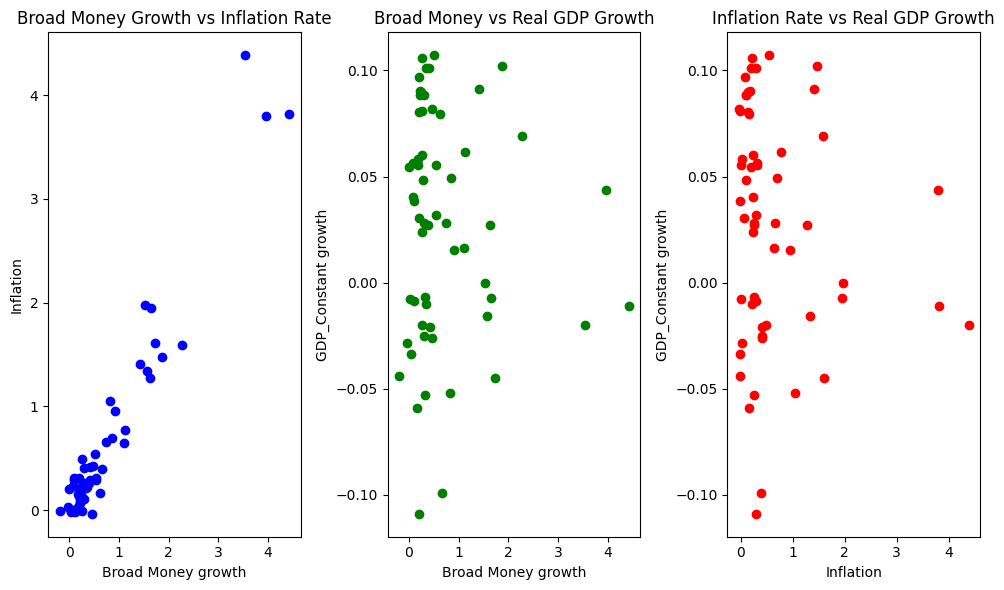

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(10, 6))

# Primer gráfico: M2 growth vs Inflation Rate
axs[0].scatter(df3['Broad_Money'], df3['Inflation'], color='blue')
axs[0].set_xlabel('Broad Money growth')
axs[0].set_ylabel('Inflation')
axs[0].set_title('Broad Money Growth vs Inflation Rate')

# Segundo gráfico: GDP real vs Inflation Rate
axs[1].scatter(df3['Broad_Money'], df3['GDP_Constant'], color='green')
axs[1].set_xlabel('Broad Money growth')
axs[1].set_ylabel('GDP_Constant growth')
axs[1].set_title('Broad Money vs Real GDP Growth')

# Tercer gráfico: Velocity of M2 vs Inflation Rate
axs[2].scatter(df3['Inflation'], df3['GDP_Constant'], color='red')
axs[2].set_xlabel('Inflation')
axs[2].set_ylabel('GDP_Constant growth')
axs[2].set_title('Inflation Rate vs Real GDP Growth')


plt.tight_layout()
plt.show()


## Linear Regression

In [19]:
x = df3['Broad_Money']
y = df3['Inflation']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [21]:
print("Lenght of Train", len(X_train))
print("Lenght of Test", len(X_test))

Lenght of Train 47
Lenght of Test 12


In [23]:
X_train_sm = sm.add_constant(X_train)
y_train = y_train.astype(float)
X_train_sm = X_train_sm.astype(float)

model = sm.OLS(y_train, X_train_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Inflation   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.919
Method:                 Least Squares   F-statistic:                     526.2
Date:                Sat, 27 Jul 2024   Prob (F-statistic):           1.82e-26
Time:                        18:43:33   Log-Likelihood:                -2.8794
No. Observations:                  47   AIC:                             9.759
Df Residuals:                      45   BIC:                             13.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0795      0.050     -1.603      

In [26]:
X_test_sm = sm.add_constant(X_test)
y_pred = model.predict(X_test_sm)

1. Comprobamos linealidad

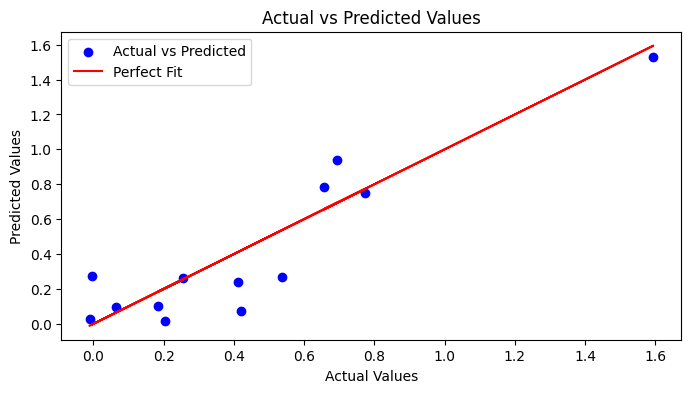

In [77]:
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, color = 'blue', label = 'Actual vs Predicted' )
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot(y_test, y_test, color='red', label='Perfect Fit')
plt.legend()
plt.show()

2. Comprobamos que los residuos esten distribuidos aleatoriamente sin ningún patrón aparente

In [28]:
mean_residuals = np.mean(model.resid)
np.round(mean_residuals,2)

np.float64(0.0)

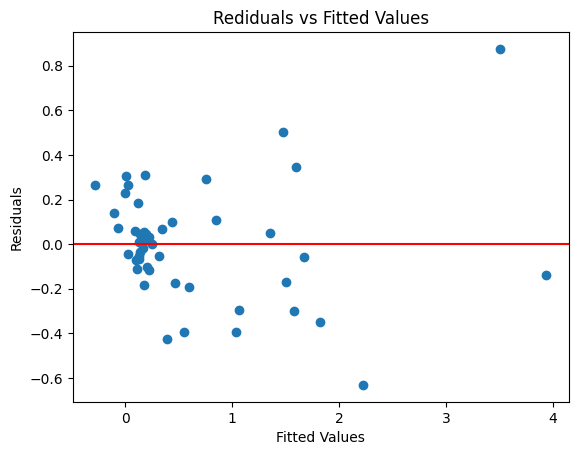

In [30]:
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(y=0, color = 'red')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Rediduals vs Fitted Values')
plt.show()

3. Revisamos independencia de las observaciones de Broad Money respecto a los residuos

In [25]:
correlation = np.corrcoef(X_train, model.resid)[0,1]
print(f"Correlation between Broad Money and residuals: {np.round(correlation,2)}")

Correlation between Broad Money and residuals: 0.0


4. Revisamos la homoscedasticidad

In [32]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Realizar la prueba de Breusch-Pagan para medir homoscedasticidad

bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_test_stat, bp_test_p_value = bp_test[1], bp_test[0]

print(f'Breusch-Pagan test p-value: {bp_test_p_value}')

Breusch-Pagan test p-value: 16.84510417004581


No hay heteroscedasticidad significativa en el modelo.

5. Comprobamos la normalidad de los residuos

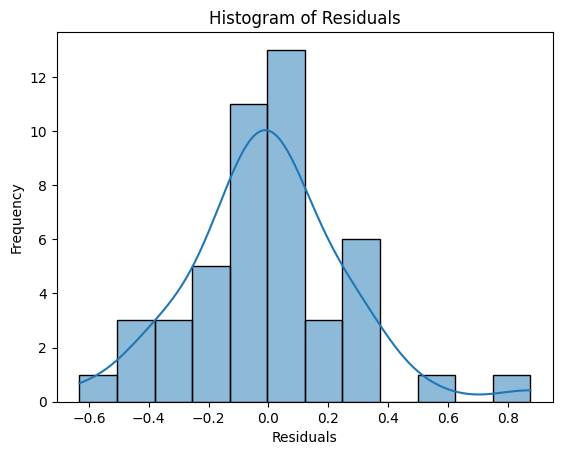

In [33]:
sns.histplot(model.resid, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

Prueba de normalidad de los residuos

In [26]:
from scipy import stats

# Prueba de Shapiro-Wilk
stat, p_value = stats.shapiro(model.resid)

print(f'Statistic: {stat}')
print(f'p-value: {p_value}')

alpha = 0.05
if p_value > alpha:
    print('Los residuos parecen seguir una distribución normal (no se rechaza H0).')
else:
    print('Los residuos no siguen una distribución normal (se rechaza H0).')

Statistic: 0.96221495010534
p-value: 0.1316937770653241
Los residuos parecen seguir una distribución normal (no se rechaza H0).


Regresion alternativa

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adj_r2}")

Mean Squared Error: 0.04348217523889266
Root Mean Squared Error: 0.20852380017372757
R-squared: 0.9547631459405224
Adjusted R-squared: 0.9502394605345746


## Granger Causality

ADF test para comprobar si las series de datos son estacionarias

In [38]:
from statsmodels.tsa.stattools import adfuller

variables = df[['Broad_Money', 'Inflation']]

# Función para verificar la estacionariedad con la prueba ADF
def check_stationarity(time_series, series_name):
    result = adfuller(time_series)
    adf_statistic = result[0]
    p_value = result[1]
    print(f'{series_name} ADF Statistic: {adf_statistic}')
    print(f'{series_name} p-value: {p_value}')
    if p_value < 0.05:
        print(f'{series_name} es estacionaria\n')
    else:
        print(f'{series_name} no es estacionaria\n')


check_stationarity(variables['Broad_Money'], 'Broad_Money')
check_stationarity(variables['Inflation'], 'Inflation')



Broad_Money ADF Statistic: -4.654151562899428
Broad_Money p-value: 0.00010252445060819894
Broad_Money es estacionaria

Inflation ADF Statistic: -5.13456040708069
Inflation p-value: 1.1940906674110305e-05
Inflation es estacionaria



In [50]:
# Dividimos los datos en entrenamiento y prueba
train_size = int(len(df) * 0.6)  
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Selección de las columnas relevantes
variables_train = train_data[['Broad_Money', 'Inflation']]
variables_test = test_data[['Broad_Money', 'Inflation']]

In [53]:
from statsmodels.tsa.stattools import grangercausalitytests

gc_results_train = grangercausalitytests(variables_train[['Broad_Money', 'Inflation']], 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.9960 , p=0.0022  , df_denom=33, df_num=1
ssr based chi2 test:   chi2=11.9957 , p=0.0005  , df=1
likelihood ratio test: chi2=10.3533 , p=0.0013  , df=1
parameter F test:         F=10.9960 , p=0.0022  , df_denom=33, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.5701  , p=0.0407  , df_denom=30, df_num=2
ssr based chi2 test:   chi2=8.3303  , p=0.0155  , df=2
likelihood ratio test: chi2=7.4727  , p=0.0238  , df=2
parameter F test:         F=3.5701  , p=0.0407  , df_denom=30, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4685  , p=0.0835  , df_denom=27, df_num=3
ssr based chi2 test:   chi2=9.3255  , p=0.0253  , df=3
likelihood ratio test: chi2=8.2410  , p=0.0413  , df=3
parameter F test:         F=2.4685  , p=0.0835  , df_denom=27, df_num=3


In [54]:
gc_results_test = grangercausalitytests(variables_test[['Broad_Money', 'Inflation']], 3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=11.1370 , p=0.0030  , df_denom=22, df_num=1
ssr based chi2 test:   chi2=12.6557 , p=0.0004  , df=1
likelihood ratio test: chi2=10.2402 , p=0.0014  , df=1
parameter F test:         F=11.1370 , p=0.0030  , df_denom=22, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.7746  , p=0.0209  , df_denom=19, df_num=2
ssr based chi2 test:   chi2=12.0623 , p=0.0024  , df=2
likelihood ratio test: chi2=9.7726  , p=0.0075  , df=2
parameter F test:         F=4.7746  , p=0.0209  , df_denom=19, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2771  , p=0.0213  , df_denom=16, df_num=3
ssr based chi2 test:   chi2=18.4449 , p=0.0004  , df=3
likelihood ratio test: chi2=13.5440 , p=0.0036  , df=3
parameter F test:         F=4.2771  , p=0.0213  , df_denom=16, df_num=3


La causalidad de Granger encontrada en el conjunto de entrenamiento se confirma en el conjunto de prueba para los dos primeros lags, lo que indica que el modelo es robusto en términos de detección de causalidad para el lag 1 y 2. Podemos decir que la Inflación es causada en términos de Granger por la Oferta Monetaria mirando los 2 primeros lags.

## Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor

X = df[['Broad_Money']]
y = df['Inflation']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.032874080269484976
R-squared: 0.8111257598143947


El modelo random forest, capaz de capturar relaciones no lineales e incluyendo a su vez valores muy atípicos no incluidos en la regresión lineal, ha mostrado un buen desempeño en el análisis de la oferta monetaria en relación con la inflación. La alta capacidad predictiva y el ajuste razonable refuerzan la comprensión de la influencia de la oferta monetaria sobre la inflación y complementan los resultados obtenidos en la regresión lineal.

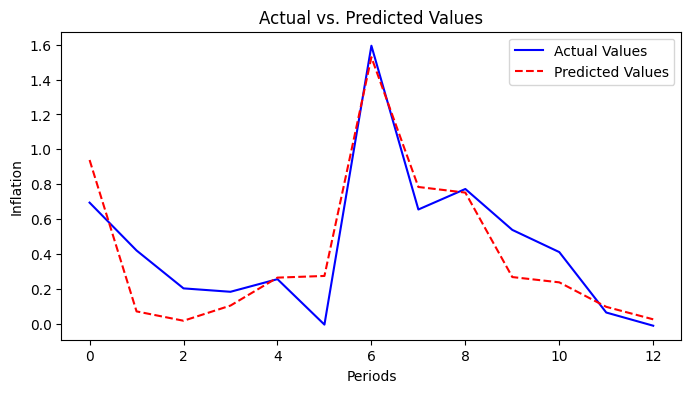

In [69]:
x = np.arange(len(y_test))

# Crear el gráfico
plt.figure(figsize=(8, 4))
plt.plot(x, y_test, color='blue', label='Actual Values')
plt.plot(x, y_pred, color='red', linestyle='--', label='Predicted Values')

# Añadir etiquetas y título
plt.xlabel('Periods')
plt.ylabel('Inflation')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()